# Set up

In [1]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

# Define Model

In [4]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

# Define different methods
- best: pick the domain that gives the highest score
- middle ground: picking something in the middle, might need to aggregate the results
- worst: pick the domain that gives the lowest score

Apply these methods and compare. We are hoping to see that the orders do matter and the "patient" ends up in different places after trying all 14 domains.

## Helper Functions

In [6]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [7]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [8]:
# given current scores and encoding, return what can be put into the model
def create_model_data(data, encoding):
    data_scores = create_missing_indicator(data)
    output = add_encoding(data_scores, encoding)
    return output

In [9]:
# given the number of rows and cols and index, return a numpy array of according size with all 0s except for specified column
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [10]:
# return prediction given model and input data
def predict(model, x):
    model.eval()
    with torch.no_grad():
        predictions = model(x)
        return predictions.clone().numpy()

In [11]:
def max_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    max_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    max_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            max_idx = np.argmax(valid_differences)  # Find index of max value (relative to valid_indices)
            max_indices[i] = valid_indices[max_idx]  # Store original column index
            max_values[i] = prediction_matrix[i, valid_indices[max_idx]]  # Get corresponding prediction value

    return max_values, max_indices

In [12]:
def min_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    min_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    min_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            min_idx = np.argmin(valid_differences)  # Find index of max value (relative to valid_indices)
            min_indices[i] = valid_indices[min_idx]  # Store original column index
            min_values[i] = prediction_matrix[i, valid_indices[min_idx]]  # Get corresponding prediction value

    return min_values, min_indices

In [13]:
def random_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    random_indices = np.full(difference_matrix.shape[0], np.nan)  # Store random indices
    random_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            chosen_idx = np.random.choice(valid_indices)  # Choose one at random
            random_indices[i] = chosen_idx
            random_values[i] = prediction_matrix[i, chosen_idx]  # Get corresponding prediction value

    return random_values, random_indices


In [14]:
# take in initial data, mode, and model, return the next domain and predicted score according to mode
def find_next_domain(initial_scores, model, mode):
    prediction_list = [] # initialize where to store the prediction scores
    for i in range(14):
        rows, cols = initial_scores.shape
        # create encoding
        encoding = create_single_encoding(rows, cols, i)
        # create data to put into model
        x = create_model_data(initial_scores, encoding)
        # predict the score if its domain i and append to prediction list
        single_prediction = predict(model, x)
        prediction_list.append(single_prediction[:, i])
    prediction_matrix = np.column_stack(prediction_list)
    difference = prediction_matrix - np.nan_to_num(initial_scores)
    # choose based on mode
    if mode == "best":
        # find max indices
        value, index = max_prediction_from_difference(difference, prediction_matrix, initial_scores)
    elif mode == "middle":
        value, index = random_prediction_from_difference(difference, prediction_matrix, initial_scores)
    elif mode == "worst":
        value, index = min_prediction_from_difference(difference, prediction_matrix, initial_scores)
    return int(index[0]), value[0]

In [15]:
# take in model and mode, return a list of scores according to the mode
def trajectory(model, mode):
    performance = [] # known domain average, s_i, at time step i
    order = [] # order of domains practiced
    current_scores = np.empty((1,14))
    current_scores[:] = np.nan # current scores, filled by nans first
    # go through 14 steps of predictions
    for i in range(14):
        # find predicted domain and score in this step according to mode
        next_domain, next_score = find_next_domain(current_scores, model, mode)
        # update current scores
        current_scores[0, next_domain] = next_score
        # calculate known domain average
        cur_mean = np.nanmean(current_scores)
        # append to score list and order list
        performance.append(cur_mean)
        order.append(next_domain + 1)
    return performance, current_scores, order

## Best

In [16]:
best_peformance, best_final_scores, best_order = trajectory(model, "best")

## Middle Ground

In [17]:
middle_peformance, middle_final_scores, middle_order = trajectory(model, "middle")

## Worst

In [18]:
worst_peformance, worst_final_scores, worst_order = trajectory(model, "worst")

# Visualizations

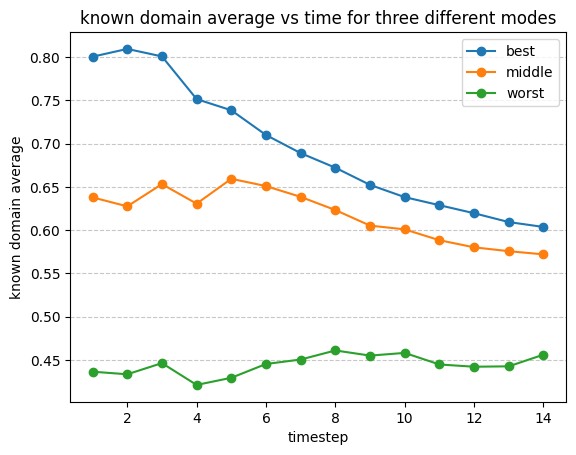

In [19]:
plt.figure()
x_values = range(1, 15)
plt.plot(x_values, best_peformance, label="best", marker="o")
plt.plot(x_values, middle_peformance, label="middle", marker="o")
plt.plot(x_values, worst_peformance, label="worst", marker="o")

plt.xlabel("timestep")
plt.ylabel("known domain average")
plt.title("known domain average vs time for three different modes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

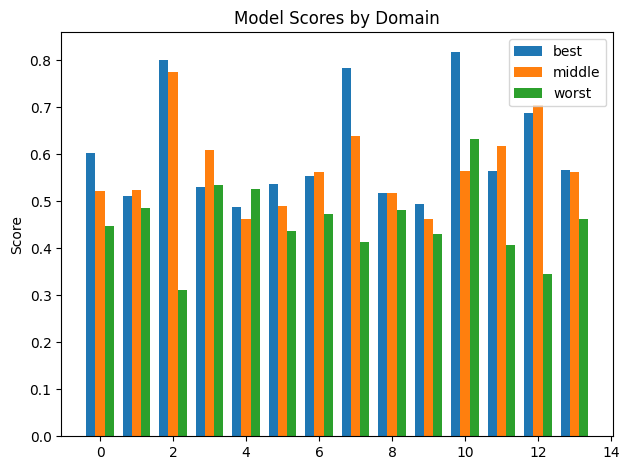

In [20]:
plt.figure()
x = np.arange(14)
width = 0.25

plt.bar(x - width, best_final_scores.flatten(), width, label='best')
plt.bar(x, middle_final_scores.flatten(), width, label='middle')
plt.bar(x + width, worst_final_scores.flatten(), width, label='worst')

plt.ylabel('Score')
plt.title('Model Scores by Domain')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
best_order, middle_order, worst_order

([3, 11, 8, 1, 13, 14, 12, 7, 10, 2, 6, 9, 5, 4],
 [8, 12, 13, 7, 3, 4, 11, 9, 10, 14, 5, 6, 1, 2],
 [6, 10, 7, 13, 14, 5, 9, 4, 12, 2, 3, 8, 1, 11])

Bad pipe message: %s [b'\x8f\xe97\t\xe9\xd5\x14\xad\xcal\xf1\xd1\xf5\x13!\x85\x1d\x9a\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00']
Bad pipe message: %s [b'\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004']
Bad pipe message: %s [b'\xda\x00\x89?,!\xfe\xa03h\x88\xce\x8d\xf8\xe8i\xdd\x17\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00', b'B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00']
Bad pipe 